# Assignment 2

In [474]:
import pandas as pd
import seaborn as sns 
from matplotlib import pyplot as plt
import numpy as np
import math
from scipy import stats
from IPython.display import Image
import re
import sys; sys.path.append('/frazer01/home/joreyna/repos/CSE-280a/Assignment_1/')
import phylo 
from scipy.stats import chisqprob
from scipy.misc import comb
import random
%matplotlib inline

In [475]:
def print_list(l, name='list', tabs=0):
    tab1 = '\t' * tabs
    print('{}{}'.format(tab1, name))
    tab2 = '\t' * (tabs + 1)
    for row in l:
        print('{}{}'.format(tab2, row))

## Question 1

(25pts) For the data-set provided, compute LD for all pairs of columns, using the D0 measure.

### Part 1(a)

Plot the LD as a matrix as shown in the graphic (Figure 1). Use the LD values to identify Haplotype blocks (regions
with little to no recombination). 

#### Functions

In [476]:
def calculate_probabilities(site1, site2, data):
    
    #     print 'calculate_ld function'
    #     print('\tsite1: {}, site2: {}'.format(site1, site2))
    #     print('\tdata: {}'.format(data))
    #     print
    sites00 = 0
    site1_0 = 0
    site2_0 = 0
    
    i = 0
    while i < len(data):
        
        #         print('')
        
        allele1 = data[i][site1]
        allele2 = data[i][site2]
        
        #         print '\ti: {}, [allele1, allele2]: [{}, {}]'.format(i, allele1, allele2)
        

        # Counting the number of 00 haplotypes 
        if [allele1, allele2] == [0, 0]:
            sites00 += 1
        
        # Counting the number of 0* 
        if allele1 == 0:
            site1_0 += 1
        
        # Counting the number of 0* 
        if allele2 == 0:
            site2_0 += 1
        
        i += 1
    
    prob00 = float(sites00) / len(data)
    prob1_0 = float(site1_0) / len(data)
    prob2_0 = float(site2_0) / len(data)
    
#     print('sites00: {}, sites1 wild: {}, sites2 wild: {}'.format(sites00, site1_0, site2_0))
#     print('data length: {}, prob00: {}, prob1 wild: {}, prob2 wild: {}')
        
#     print
#     print '\tsites00: {}, site1_0: {}, site2_0: {}, n: {}'.format(sites00, site1_0, site2_0, len(data))
#     print
#     print '\tprob1_0: {}, prob2_0: {}, prob00: {}, prob P0* x P*0: {}'.\
#         format(prob1_0, prob2_0, prob00, prob1_0 * prob2_0)
    
    return [prob00, prob1_0,  prob2_0]

In [477]:
def calculate_ld_prime(site1, site2, probs, ld_arr):

    prob00 = probs[site1][site2][0]
    prob1_wild = probs[site1][site2][1]
    prob1_mut = 1 - prob1_wild 
    prob2_wild = probs[site1][site2][2]
    prob2_mut = 1 - prob2_wild
    d = ld_arr[site1][site2]
    
    # Normalizing depending on the value of D
    if d >= 0:
        norm_factor = min(prob1_wild * prob2_mut, prob1_mut * prob2_wild)
    elif d < 0:
        norm_factor = max(-prob1_wild * prob2_wild, -prob1_mut * prob2_mut)
    return d / norm_factor 

In [478]:
def calculate_chisquared_pvalue(site1, site2, ld_arr, probs):

    prob00 = probs[site1][site2][0]
    prob1_wild = probs[site1][site2][1]
    prob1_mut = 1 - prob1_wild 
    prob2_wild = probs[site1][site2][2]
    prob2_mut = 1 - prob2_wild
    d = ld_arr[site1][site2]
    
    roe = d / np.sqrt(prob1_wild * prob1_mut * prob2_wild * prob2_mut)
    roe_squaredN = (roe**2) * len(ld_arr)
    pvalue = chisqprob(roe_squaredN, 1)
    return -np.log(pvalue)

In [479]:
def calculate_ld_blocks_data(data):
    addtl = 0
    # Calculate the probabilities for the LD analysis 
    probs = [0] * (len(data[0]) + addtl)
    probs = [ [[0] * 3] * (len(data[0]) + addtl) for x in data[0]]
    for x in range(1, len(probs) + 1):
        for y in range(0, len(probs) - x):
            probs[y][y + x] = calculate_probabilities(y, y+x, data)

    # Calculate the D matrix
    ld_arr = [0] * (len(data[0]) + addtl)
    ld_arr = [[0] * (len(data[0]) + addtl) for x in data[0]]
    for x in range(1, len(ld_arr) + 1):
        for y in range(0, len(ld_arr) - x):
            p00 = probs[y][y+x][0]
            p1_wild = probs[y][y+x][1]
            p2_wild = probs[y][y+x][2]
            ld_arr[y][y + x] =  p00 - p1_wild * p2_wild
            #print('p00: {}, p1_wild: {}, p2_wild: {}'.format(p00, p1_wild, p2_wild))

    # Calculate the D matrix
    ld_prime_arr = [0] * (len(data[0]) + addtl)
    ld_prime_arr = [[0] * (len(data[0]) + addtl) for x in data[0]]
    for x in range(1, len(ld_prime_arr) + 1):
        for y in range(0, len(ld_prime_arr) - x):
            ld_prime_arr[y][y + x] =  calculate_ld_prime(y, y + x, probs, ld_arr)

    # Calculate the D prime matrix
    ld_prime_arr = [0] * (len(data[0]) + addtl)
    ld_prime_arr = [[0] * (len(data[0]) + addtl) for x in data[0]]
    for x in range(1, len(ld_prime_arr) + 1):
        for y in range(0, len(ld_prime_arr) - x):
            ld_prime_arr[y][y + x] =  calculate_ld_prime(y, y + x, probs, ld_arr)
            
    p_arr = [0] * (len(data[0]) + addtl)
    p_arr = [[0] * (len(data[0]) + addtl) for x in data[0]]
    for x in range(1, len(p_arr) + 1):
        for y in range(0, len(p_arr) - x):
            p_arr[y][y + x] = calculate_chisquared_pvalue(y, y+x, ld_arr, probs)
            
    return probs, ld_arr, ld_prime_arr, p_arr

#### Load data

In [480]:
debug = False  
simple_data = [[0,1], [0,1], [0,0], [0,0], [1,0], [1,0], [1,0], [1,0]]

if debug:
    data = simple_data
else:
    data = []
    with open('a2data1.txt', 'r') as f:
        for i, row in enumerate(f):
            row_data = []
            for digit in row.strip():
                row_data.append(int(digit))
            data.append(row_data)

In [481]:
# Analyze the matrix information 
probs, ld_arr, ld_prime_arr, p_arr = calculate_ld_blocks_data(data)

#### Visualizing the D matrix

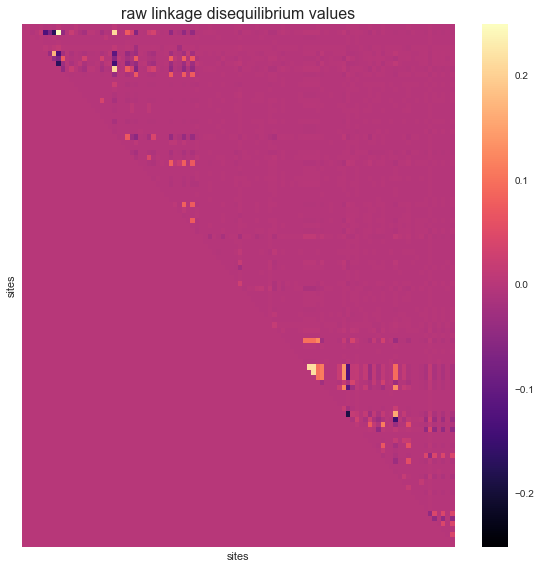

In [482]:
fig = plt.figure(figsize=(8,8))
ax = sns.heatmap(ld_arr, xticklabels=False, yticklabels=False, cmap='magma')
ax.set_title('raw linkage disequilibrium values', fontdict={'fontsize': 16,})
ax.set_xlabel('sites')
ax.set_ylabel('sites')
fig.tight_layout()

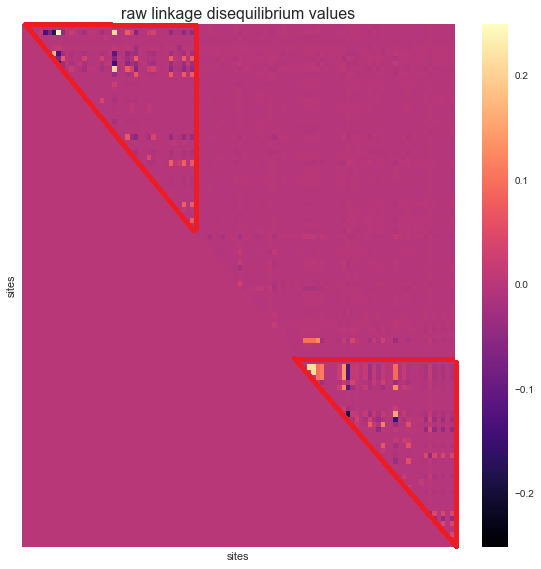

In [483]:
Image(filename='/frazer01/home/joreyna/shared_drive/CSE-280a/Assignment_2/question1_d_matrix_anno.png')

With some difficulty, it looks as if there are two haplotype blocks which are visually depicted by the image above. 

#### Visualizing the D prime matrix

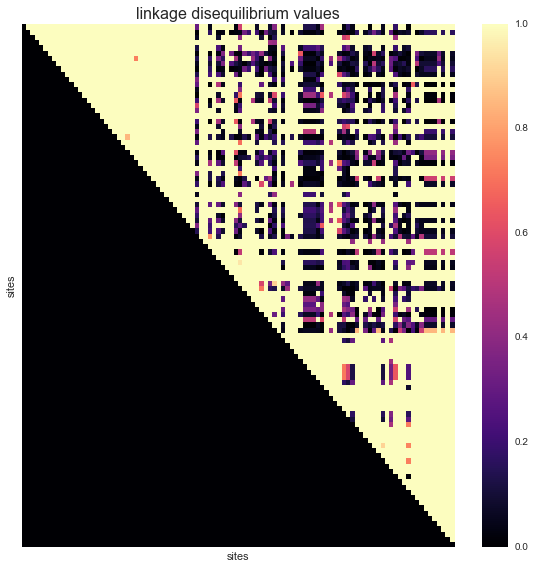

In [484]:
fig = plt.figure(figsize=(8,8))
ax = sns.heatmap(ld_prime_arr, xticklabels=False, yticklabels=False, cmap='magma')
ax.set_title('linkage disequilibrium values', fontdict={'fontsize': 16,})
ax.set_xlabel('sites')
ax.set_ylabel('sites')
fig.tight_layout()

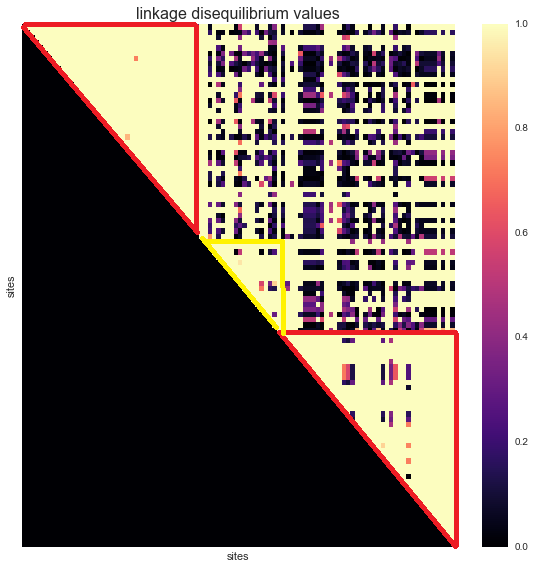

In [485]:
Image(filename='/frazer01/home/joreyna/shared_drive/CSE-280a/Assignment_2/question1_dprime_matrix_anno.png')

By computing the D prime we can see that the haplotype blocks are most likely found at sites indicated the red triangles in the image above and there could potentially be a haplotype in the middle sites which is indicated by the yellow triangle. 

### Part 1(b)

Use lecture notes to convert the D0statistic into an appropriate Pvalue. Redo the matrix by replacing the D0 value with − log(P-value).

#### Visualizing the p-value matrix

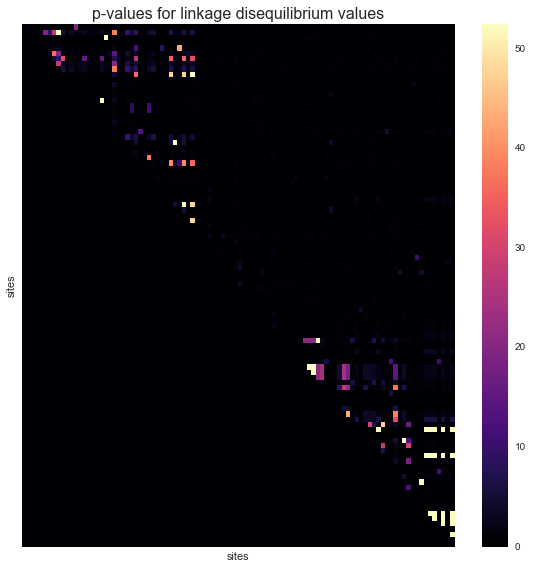

In [486]:
fig = plt.figure(figsize=(8, 8))
ax = sns.heatmap(p_arr, xticklabels=False, yticklabels=False, cmap='magma')
ax.set_title('p-values for linkage disequilibrium values', fontdict={'fontsize': 16,})
ax.set_xlabel('sites')
ax.set_ylabel('sites')
fig.tight_layout()

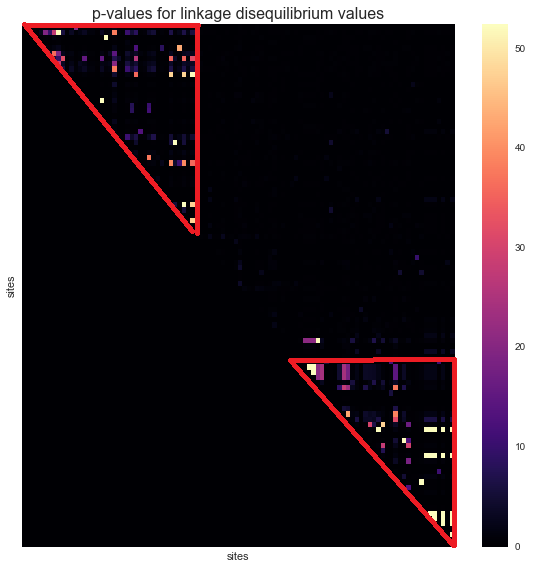

In [487]:
Image(filename='/frazer01/home/joreyna/shared_drive/CSE-280a/Assignment_2/question1_pvalue_matrix_anno.png')

The calculations of p-values provides some confidence in our haplotypes blocks. In the D matrix plot we notice two potential haplotypes. The number of potential haplotypes increased in the D primte matrix plot but results from the p value plot help us to confidently say the top left and bottom right haplotypes are the only haplotypes present in the SNP array. 

## Question 2

(25pts) Download the coalescent simulator msms from http://www.mabs.at/ewing/msms/index.shtml, and
go through its manual.

### Part 2(a)

 Write the msms command for simulating a single sample of n = 100 individual haplotypes sampled
from a region with scaled mutation rate θ = 100, and no recombination. Use the command to generate
a random sample, and show that indeed there is no evidence of historical recombination.

##### MSMS command

-ms 100 1 -t 100

#### Investigating the recombination of the SNP array

In [488]:
data = []
with open('/frazer01/home/joreyna/shared_drive/CSE-280a/Assignment_2/question_2a.txt', 'r') as f:
    f.readline()
    f.readline()
    for i, row in enumerate(f):
        row_data = []
        for digit in row.strip():
            row_data.append(int(digit))
        data.append(row_data)
data = data[:-1]

In [489]:
probs, ld_arr, ld_prime_arr, p_arr = calculate_ld_blocks_data(data)

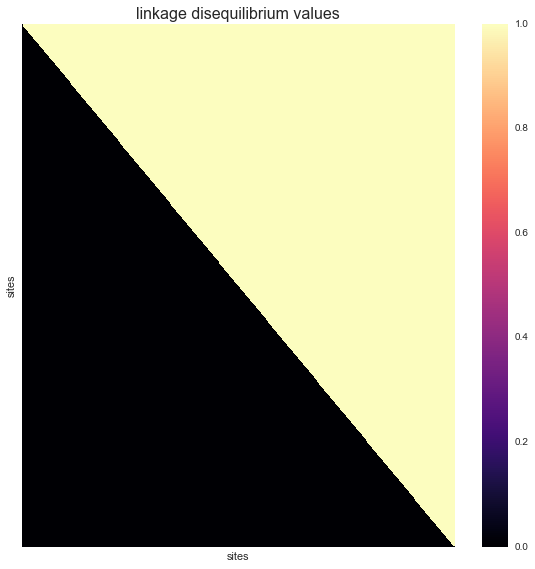

In [490]:
fig = plt.figure(figsize=(8,8))
ax = sns.heatmap(ld_prime_arr, xticklabels=False, yticklabels=False, cmap='magma')
ax.set_title('linkage disequilibrium values', fontdict={'fontsize': 16,})
ax.set_xlabel('sites')
ax.set_ylabel('sites')
fig.tight_layout()

##### Evaluating the perfect phylogeny of the SNP array

In [491]:
snp_array = data
t_array = phylo.transpose_array(snp_array)
t_array.sort(reverse=True)

answer = 'No'
if phylo.is_perfect_phylo(t_array):
    answer = 'Yes'
print('Does the data have perfect phylogeny?: {}'.format(answer))

Does the data have perfect phylogeny?: Yes


##### Conclusion

The SNP array for this problem clearly does not have recombination. On the upper right had corner of the D prime plot we have a solid linkage desequilibrium block illustrated by the solid red triangle and this conveys that recombination could not have occured in this population. Similarly, investigating the perfect phylogeny we see that the SNP array does have perfect phylogeny which again argues that we do have a population without recombination events.  

### Part 2(b)

 Generate 1,000 samples, all with n = 100, θ = 100 and compute the distribution (histogram) of the
number of columns in the 1,000 samples. Compute the mean and variance of the number of columns
from the distribution, and explain why the sampled mean makes sense (or not). Non-credit. Explain
the sampled variance

-ms 100 1000 -t 100

#### Plotting a histogram of column sizes 

In [492]:
def load_segsites_data(fn):
    with open(fn, 'r') as f:
        data = []
        for line in f:
            match = re.search('segsites: ([0-9]*)', line)
            if match:
                sites = int(match.groups()[0])
                data.append(sites)

    return data 

In [493]:
data = load_segsites_data('/frazer01/home/joreyna/shared_drive/CSE-280a/Assignment_2/question_2b.txt')

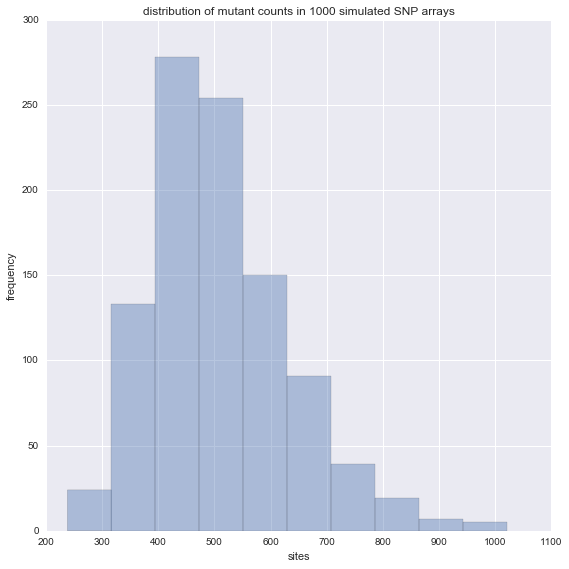

In [494]:
fig = plt.figure(figsize=(8,8))
ax = sns.distplot(data, kde=False, hist=True, bins=10)
ax.set_title('distribution of mutant counts in 1000 simulated SNP arrays')
ax.set_xlabel('sites')
ax.set_ylabel('frequency')
fig.tight_layout()

#### Summary data

In [498]:
print 'The mean of the data is: {}'.format(np.mean(data))

The mean of the data is: 510.893


In [499]:
print 'The variance of the data is: {}'.format(np.var(data))

The variance of the data is: 15585.043551


In [500]:
print 'The standard deviation of the data is: {}'.format(np.std(data))

The standard deviation of the data is: 124.840071896


By comparing the mean number of columns in the simulations with an estimate, I show that the mean reasonably captures the number of columns we would expect. The equation for estimating the number of mutations given a sample population with a mutation rate theta is E(m) = theta * ln(n). For this question our sample population is 100 and our theta is 100. Therefore, the estimated number of columns is 460. The calculated mean was 510 which is only 50 columns/sites more than the estimate. This is reasonable given 460 falls within the first standard deviation.

#### Doing the same for exponential MSMS

In [535]:
!java -jar /frazer01/home/joreyna/shared_drive/CSE-280a/Assignment_2/msms/lib/msms.jar \
    -ms 100 1000 -t 100 -G 0.69314718055994529 > \
    /frazer01/home/joreyna/shared_drive/CSE-280a/Assignment_2/question_2_extra.txt

In [536]:
data = load_segsites_data('/frazer01/home/joreyna/shared_drive/CSE-280a/Assignment_2/question_2_extra.txt')

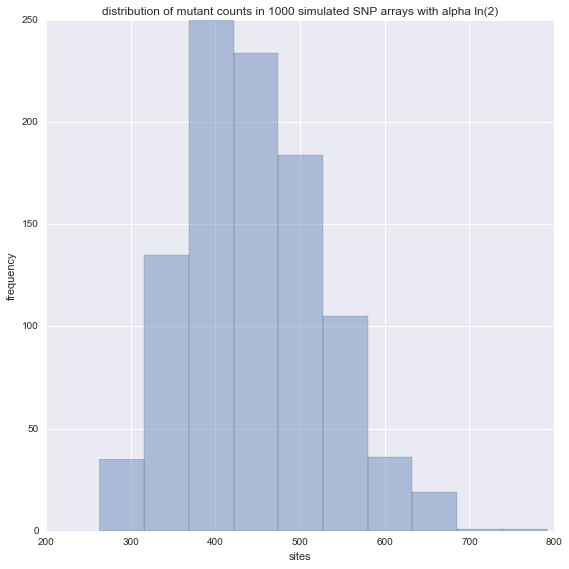

In [538]:
fig = plt.figure(figsize=(8,8))
ax = sns.distplot(data, kde=False, hist=True, bins=10)
ax.set_title('distribution of mutant counts in 1000 simulated SNP arrays with alpha ln(2)')
ax.set_xlabel('sites')
ax.set_ylabel('frequency')
fig.tight_layout()

In [539]:
print 'The mean of the data is: {}'.format(np.mean(data))

The mean of the data is: 446.308


In [540]:
print 'The variance of the data is: {}'.format(np.var(data))

The variance of the data is: 6420.201136


In [541]:
print 'The standard deviation of the data is: {}'.format(np.std(data))

The standard deviation of the data is: 80.1261576266


## Question 3

 (25pts) You are given samples from two non-mixing populations, each containing n = 200 haploids in
the sample. The two populations have been evolving neutrally with unknown but identical mutation and
recombination rates. One of the two populations has had exponential growth, while the other has evolved
according to the neutral Wright Fisher model. Determine which population has had exponential growth,
and explain your reasoning.


#### Plan

To compare population A and B I will take a look at the haplotype blocks as well as perform simulations that model the Wright Fisher model using recombination. 

In [588]:
def load_data(fn):
    with open(fn, 'r') as f:
        segsites = int(f.readline().split()[1])
        positions = [float(x) for x in f.readline().split()[1:]]
        data = []
        for row in f:
            row_data = []
            for digit in row.strip():
                row_data.append(int(digit))
            data.append(row_data)
        
    return segsites, positions, data 

In [ ]:
def load_data_test(fn):
    with open(fn, 'r') as f:
        f.readline().strip()
        f.readline().strip()
        f.readline().strip()
        f.readline().strip()
    
        segsites = int(f.readline().split()[1])
        positions = [float(x) for x in f.readline().split()[1:]]
        data = []
        for row in f:
            row_data = []
            for digit in row.strip():
                row_data.append(int(digit))
            data.append(row_data)
        data = data[:-1]
        
    return segsites, positions, data 

#### LD Values

In [613]:
# Population A
segsites_a, positions_a, snp_array_a = load_data('popA.txt')
snp_array_a = snp_array_a[:-1]
probs, ld_arr, ld_prime_arr, p_arr = calculate_ld_blocks_data(snp_array_a)

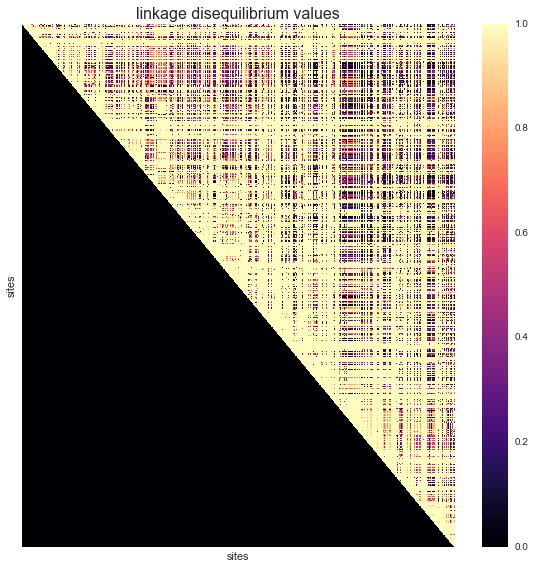

In [615]:
fig = plt.figure(figsize=(8,8))
ax = sns.heatmap(ld_prime_arr, xticklabels=False, yticklabels=False, cmap='magma')
ax.set_title('linkage disequilibrium values', fontdict={'fontsize': 16,})
ax.set_xlabel('sites')
ax.set_ylabel('sites')
fig.tight_layout()

In [616]:
# Population B
segsites_b, positions_b, snp_array_b = load_data('popB.txt')
snp_array_b = snp_array_b[:-1]
probs, ld_arr, ld_prime_arr, p_arr = calculate_ld_blocks_data(snp_array_b)

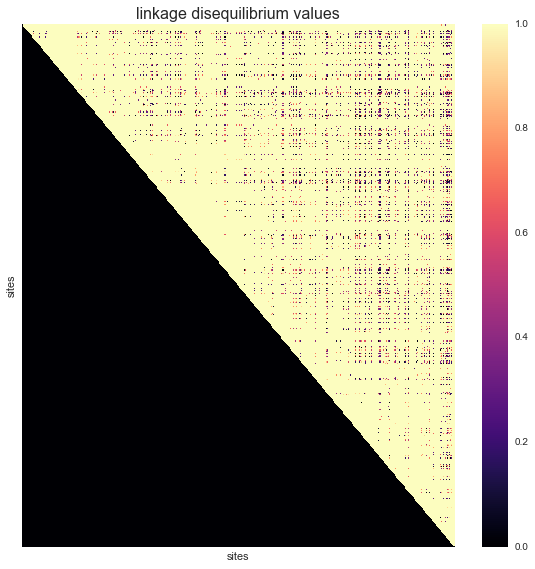

In [618]:
fig = plt.figure(figsize=(8,8))
ax = sns.heatmap(ld_prime_arr, xticklabels=False, yticklabels=False, cmap='magma')
ax.set_title('linkage disequilibrium values', fontdict={'fontsize': 16,})
ax.set_xlabel('sites')
ax.set_ylabel('sites')
fig.tight_layout()

#### Allele spectrum

In [787]:
# # Population A
# snp_df_a = pd.DataFrame(snp_array_a)
# data = snp_df_a.sum(axis=0)
# fig = plt.figure(figsize=(8,8))
# ax = sns.distplot(data, kde=False, hist=True, bins=10)
# ax.set_title('Allele spectrum')
# ax.set_xlabel('sites')
# ax.set_ylabel('frequency')
# fig.tight_layout()

In [788]:
# # Population B
# snp_df_b = pd.DataFrame(snp_array_b)

# data = snp_df_b.sum(axis=0)
# fig = plt.figure(figsize=(8,8))
# ax = sns.distplot(data, kde=False, hist=True, bins=10)
# ax.set_title('Allele spectrum')
# ax.set_xlabel('sites')
# ax.set_ylabel('frequency')
# fig.tight_layout()

#### Tajima's estimate and estimating the number of mutations 

In [769]:
def hamming_dist(data):
    """
    Calculate Tajima's theta.
    """
    
    het_score = 0
    for x in range(0, len(data)):
        for y in range(x + 1, len(data)):
            for z in range(len(data[0])):
                if data[x][z] != data[y][z]:
                    het_score += 1
    return het_score

In [776]:
hamming_dist_a = hamming_dist(snp_array_a)
theta_a = 1/comb(len(snp_array_a), 2) * hamming_dist_a

In [778]:
print('Estimating the columns of population A: {}'.format(theta_a * np.log(len(snp_array_a))))

Estimating the columns of population A: 1007.91541996


In [780]:
hamming_dist_b = hamming_dist(snp_array_b)
theta_b = 1/comb(len(snp_array_b), 2) * hamming_dist_b

In [783]:
print('Estimating the columns of population B: {}'.format(theta_b* np.log(len(snp_array_b))))

Estimating the columns of population B: 208.417167903


To investigate these two different populations I analyzed the linkage disequilibrium, allele spectrum and estimated the number of expected columns for each dataset. The linkage disequilibrium results show that population B has more LD than population A. The time between coalesence events in a population with exponential growth is very short and therefore there is very little time for recombination so these LD patterns seem to suggest that population B is the exponentially growing population. I then took a look at the expected number of mutations by estimating theta using Tajima's approach and applied theta to E[m] = theta * ln(n). Given the SNP array for population B we see that only 208 mutations wer 

To investigate these two different populations I analyzed the linkage disequilibrium, allele spectrum and estimated the number of expected columns for each dataset. The linkage disequilibrium results show that population B has more LD than population A. The time between coalesence events in a population with exponential growth is very short and therefore there is very little time for recombination so these LD patterns seem to suggest that population B is the exponentially growing population. I then took a look at the allele spectrum where for exponentially growing populations you expect to see fewer mutations. In the allele spectrum for B we see that many alleles were represented only a few ti


Lastly I estimated the expected number of mutations by estimating theta using Tajima's approach and applied this theta to E[m] = theta * ln(n). Given the SNP array for population A we again predicted 

## Question 4

(25pts) 

### Part 4(a)

Design and implement a no-recombination, coalescent based backward simulator that outputs
a sample (a haplotype SNP matrix with n rows) evolving neutrally but with exponential growth in the
population. The input to your simulator is a set of parameters: sample size n, θ, current population N,
and with growth rate parameter α. To explain the use of growth rate, let Nt denote the population size t
generations prior to the current generation. Then, N0 = N, and Nt = ef−αNt−1.

#### Psudeocode

#### Implementation

In [ ]:
def print_tree(tree, tabs=0):
    tab_str = '\t' * tabs
    for k, v in tree.items():
        print '{}id: {}, {}'.format(tab_str, k, v.message(tabs = tabs))

def print_dict(tree, tabs=0):
    tab_str = '\t' * tabs
    for k, v in tree.items():
        print '{}id: {}, {}'.format(tab_str, k, v)

def print_avail_nodes(tree, tabs=0):
    tab_str = '\t' * tabs
    for k, v in tree.items():
        print '{}id: {}'.format(tab_str, k)

def print_parameters():    
    print('Coalesence Parameters')
    print('---------------------------------')
    print('Sample size: {}'.format(sample_size))
    print('Scaled mutation rate (theta): {}'.format(theta))
    print('Population size: {}'.format(population_size))
    print('Alpha growth rate: {}'.format(alpha))
    print('Region: {}\n'.format(region))

In [62]:
def get_mutations(num_muts, region, prev_mut_sites):
    muts = []
    while len(muts) < num_muts:
        mut_site = np.random.randint(1, region)
        if mut_site not in prev_mut_sites:
            muts.append(mut_site)
    return muts

In [63]:
def coin_flip(p):
    """
    Flip a coin using a random number generator.
    """
    return True if random.random() < p else False

In [64]:
class node():
    def __init__(self, name, height = 0, children_ids = [], children_muts = [], children_branches = []):
        self.name = name
        self.height = height
        self.children_ids = children_ids
        self.children_muts = children_muts
        self.children_branches = children_branches
    
    def message(self, tabs=0, skip_muts=True):
        tabs_str = '\t' * tabs 
        message = '{}name: {}\n'.format(tabs_str, self.name)
        message += '{}height: {}\n'.format(tabs_str, self.height)
        if len(self.children_ids) > 0:
            for cid, cmuts, cbranch in zip(self.children_ids, self.children_muts, self.children_branches):
                if skip_muts == True:
                    message += '{}child_id: {}, child_branch: {}\n'.format(tabs_str, cid, cbranch)
                else:
                    message += '{}child_id: {}, child_muts: {}, child_branch: {}\n'.format(tabs_str, cid, cmuts, cbranch)
        else: 
            if skip_muts == True:
                message += '{}child_id: [], child_branch: []\n'.format(tabs_str)            
            else:
                message += '{}child_id: [], child_muts: [], child_branch: []\n'.format(tabs_str)

        return message
        

In [502]:
def simulate_snp_tree_w_exp(sample_size, theta, population_size, alpha, region):
    """
    Simulated a coalesence tree given a sample size, scaled mutation rate,
    populations size, population growth, and mutational region.
    """
    skip_muts = True
    # Initializations of the tree and initial values 
    individuals = ['idv{}'.format(x + 1) for x in range(sample_size)]
    tree = {idv: node(idv) for idv in individuals} 
    avail_nodes = {k:k for k in tree.keys()}
    prev_coal_node = tree[individuals[0]]
    prev_mut_sites = []
    generation_sizes = [population_size]
    coal_lengths = [0]
    branch_len = 1 # Rounding
    epoch = 1
    
#     print('theta: {}'.format(theta))

    # Construction of the coalescence tree
    coal_count = 1
    while sample_size > 1:
                
        prev_population_size = math.exp(-alpha) * population_size
        coal_prob = comb(sample_size, 2) / (2 * prev_population_size)
        #nocoal_prob = 1 - (epoch * (epoch - 1))  / (2 * prev_population_size)
        
        # Adding a new epoch/branch length
        if coin_flip(coal_prob):
        #if not coin_flip(nocoal_prob):

            # Creating a new coalescence node
            coal_node = node('coal{}'.format(coal_count))
            # Initializing children information for printing purposes 
            coal_node.children_ids = [0,0]
            coal_node.children_branches = [0,0]
            coal_node.children_muts = [[0],[0]]        

            coal_node.height = epoch 
            tree.update({'coal{}'.format(coal_count): coal_node})

            # Choosing the left child
            left_child = random.choice(avail_nodes.keys())
            left_child_node = tree[avail_nodes.pop(left_child)]

            # Choosing the right child
            right_child = random.choice(avail_nodes.keys())
            right_child_node = tree[avail_nodes.pop(right_child)]

            # Choosing the number of mutations for each child
            left_mutuations = []

            # Update available nodes to include the newly created coalescent node 
            avail_nodes.update({'coal{}'.format(coal_count): 'coal{}'.format(coal_count) })

            # Add children ids, branch lengths and mutations 
            coal_node.children_ids = [left_child, right_child]
#             coal_node.children_branches = [left_child_node.height + branch_len, \
#                                            right_child_node.height + branch_len]

            coal_node.children_branches = [epoch - left_child_node.height, \
                                           epoch - right_child_node.height]
            
            # Dropping mutations on the left child branch
            mew = theta/(4*population_size)
            
            
            
            num_muts = coal_node.children_branches[0] * mew
            muts_left = get_mutations(num_muts, region, prev_mut_sites)
            
#             print('left child')
#             print('\tbranch_left: {}'.format(coal_node.children_branches[0]))
#             print('\tmuts_left: {}'.format(len(muts_left)))
            
            prev_mut_sites.extend(muts_left)

            # Dropping mutations on the left child branch
            num_muts = coal_node.children_branches[1] * mew
            muts_right = get_mutations(num_muts, region, prev_mut_sites)
            
#             print('\n')
#             print('right child')
#             print('\tbranch_right: {}'.format(coal_node.children_branches[1]))
#             print('\tmuts_right: {}'.format(len(muts_right)))
#             print('\n')

            prev_mut_sites.append(muts_right)    
            coal_node.children_muts = [muts_left, muts_right]

            # Bookkeeping global variables needed for exp dist, new coalescent counts, etc 
            prev_coal_node = coal_node
            sample_size -= 1
            coal_count += 1
            coal_lengths.append(branch_len)
        
        epoch += 1
        branch_len += 1
        population_size = prev_population_size 
        generation_sizes.append(population_size)
        
    return tree, generation_sizes, coal_lengths

In [503]:
def traverse_and_get_mutations(tnode, mutations, data, tree):
    """
    Traverse the coalescent tree and fill data with SNP information.
    """
    
#     print('entering node: {}'.format(tnode.name))
    
    # Base case when we have hit a leaf
    if len(tnode.children_ids) == 0:
        data[tnode.name] = mutations 
        
#         print('leaving node: {}'.format(tnode.name))

        return 
    
    for c in range(len(tnode.children_ids)):
        child_muts = tnode.children_muts[c]
        child_node = tree[tnode.children_ids[c]]
        mutations.extend(child_muts)
        traverse_and_get_mutations(child_node, mutations, data, tree)
        mutations = mutations[0: -len(child_muts)]
        
#     print('leaving node: {}'.format(tnode.name))
        
    return 

In [504]:
def simulate_snp_array_w_exp(sample_size, tree):
    """
    Given a coalesence tree generate the coalesence matrix. 
    """
    
    global data
    
    individuals = ['idv{}'.format(x + 1) for x in range(sample_size)]

    # Locating the last node denoting coalescence 
    node_ids = tree.keys()
    node_ids = [x for x in node_ids if re.search('coal', x)]
    node_ids.sort(reverse=True)
    tnode = tree[node_ids[0]]

    # Traversing the coalesence tree to extract mutations 
    mutations = []
    data = {}
    traverse_and_get_mutations(tnode, mutations, data, tree)

    # Constructing a sorted list of all the mutation sites 
    all_mutations = set()
    for node_name, muts in data.items():
        for mut in muts:
            all_mutations.add(mut)
    all_mutations = list(all_mutations)
    all_mutations.sort()

    # Making an indexer between column positions and mutations names 
    mut_indexes = {site: i for i, site in enumerate(all_mutations)}

    # Generating the SNP matrix in list form 
    snp_array = [0] * len(data)
    snp_array = [[0] * len(all_mutations) for x in range(len(data))]

    for i, indv in enumerate(individuals):
        for mut in data[indv]:
            snp_array[i][mut_indexes[mut]] = 1 
            
            
    return snp_array, all_mutations

### Part 4(b)

Simulate 100 samples for each of two cases: α = 0, and a positive (small) value of α using the
parameters provided and show qualitatively and quantitatively, how the allele frequency spectrum changes
in the exponentially growing population relative to the constant population size scenario.

#### Allele frequency spectrum

##### Case alpha = 0 

In [597]:
sample_size = 100
population_size = 1000
theta = 100
alpha = 0
region = 10000

allele_spectrum_summary = []
mut_sizes_exp = []
for x in range(100):
    coal_tree, generation_sizes, coal_lengths = \
            simulate_snp_tree_w_exp(sample_size, theta, population_size, alpha, region)
    snp_array, _ = simulate_snp_array_w_exp(sample_size, coal_tree)
    snp_df = pd.DataFrame(snp_array)
    allele_spectrum = snp_df.sum(axis=0) # Calculating allele spectrum 
    allele_spectrum = pd.DataFrame(data = [allele_spectrum.values.tolist()], columns=allele_spectrum.index)
    allele_spectrum_summary.append(allele_spectrum)

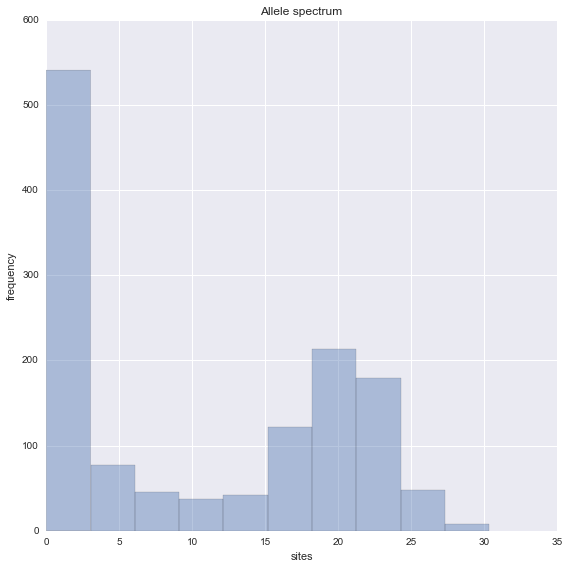

In [598]:
allele_spectrum_summary = pd.concat(allele_spectrum_summary)
allele_spectrum_summary.replace(np.NaN, 0, inplace=True)

data = allele_spectrum_summary.mean()
fig = plt.figure(figsize=(8,8))
ax = sns.distplot(data, kde=False, hist=True, bins=10)
ax.set_title('Allele spectrum')
ax.set_xlabel('sites')
ax.set_ylabel('frequency')
fig.tight_layout()

##### Case alpha small positive

In [585]:
sample_size = 10
population_size = 10**6
theta = 40
alpha = 7/(4* population_size)
region = 100000

allele_spectrum_summary = []
mut_sizes_exp = []
for x in range(10):
    coal_tree, generation_sizes, coal_lengths = \
            simulate_snp_tree_w_exp(sample_size, theta, population_size, alpha, region)
    snp_array, _ = simulate_snp_array_w_exp(sample_size, coal_tree)
    snp_df = pd.DataFrame(snp_array)
    allele_spectrum = snp_df.sum(axis=0) # Calculating allele spectrum 
    allele_spectrum = pd.DataFrame(data = [allele_spectrum.values.tolist()], columns=allele_spectrum.index)
    allele_spectrum_summary.append(allele_spectrum)

In [594]:
allele_spectrum_summary

,0,1,2,3,4,5,6,7,8,9,...,218,219,220,221,222,223,224,225,226,227
0,7,10,10,7,7,1,7,10,7,1,...,0,0,0,0,0,0,0,0,0,0
0,1,5,5,5,5,5,5,5,5,3,...,5,10,1,5,5,5,5,10,5,3
0,4,1,2,1,1,1,1,1,1,2,...,0,0,0,0,0,0,0,0,0,0
0,10,5,5,5,2,5,1,1,2,5,...,0,0,0,0,0,0,0,0,0,0
0,1,10,10,9,10,1,1,1,2,1,...,0,0,0,0,0,0,0,0,0,0
0,9,1,9,9,1,1,9,1,1,9,...,0,0,0,0,0,0,0,0,0,0
0,1,2,4,4,6,6,4,2,3,1,...,0,0,0,0,0,0,0,0,0,0
0,6,3,1,1,2,6,10,6,3,6,...,0,0,0,0,0,0,0,0,0,0
0,2,1,1,1,7,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
0,3,1,1,1,3,3,3,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
allele_spectrum_summary = pd.concat(allele_spectrum_summary)
allele_spectrum_summary.replace(np.NaN, 0, inplace=True)

In [596]:
allele_spectrum_summary_expon# = allele_spectrum_summary.copy(deep=True)

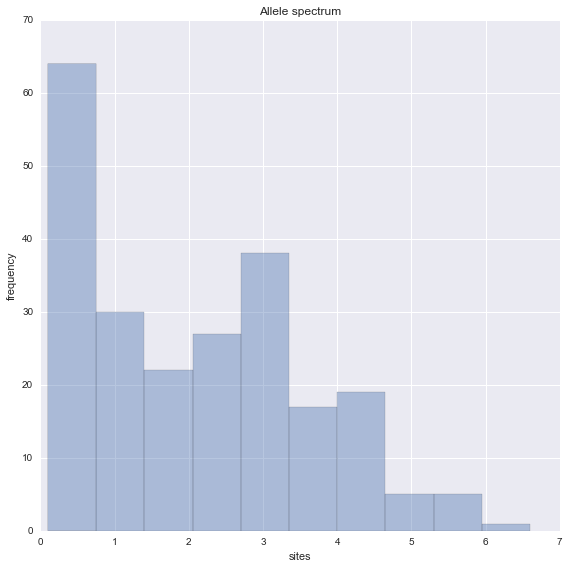

In [595]:
data = allele_spectrum_summary.mean()
fig = plt.figure(figsize=(8,8))
ax = sns.distplot(data, kde=False, hist=True, bins=10)
ax.set_title('Allele spectrum')
ax.set_xlabel('sites')
ax.set_ylabel('frequency')
fig.tight_layout()

In [560]:
# for trial in range(1):
#     coal_tree, generation_sizes, coal_lengths = \
#         simulate_snp_tree_w_exp(sample_size, theta, population_size, alpha, region)
#     snp_array, _ = simulate_snp_array_w_exp(sample_size, coal_tree)
#     snp_df = pd.DataFrame(snp_array)

# #     allele_frequencies = [0] * len(snp_array[0])
# #     for site in range(len(snp_array[0])):
# #         for idv in range(len(snp_array)):
# #             if snp_array[idv][site] == 1:
# #                 allele_frequencies[site]  += 1


In [ ]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=(8,8))
ax = sns.barplot(allele_spectrum.index, allele_spectrum.values, color='blue')
ax.set_title('Allele spectrum for 100 simuations')
fig.tight_layout()

KeyboardInterrupt: 

### Making a input files for HaploView

ped = pd.DataFrame(data)
ped.columns = ['site{}'.format(x + 1) for x in range(len(data[0]))]

# Adding one to each column to represent PED values.
for x in range(len(data[0])):
    ped['site{}'.format(x + 1)] = ped['site{}'.format(x + 1)].apply(lambda y: y + 1)
        

# Adding an additional column for each marker. A PED requirement.
for x in range(len(data[0])):
    ped['site{}b'.format(x + 1)] = ped['site{}'.format(x + 1)]

# Adding dummy colums where are required for the HaploView program.
ped['family_id'] = 0
ped['sample_id'] = ['sample{}'.format(x + 1) for x in range(len(data))]
ped['paternal_id'] = 0
ped['maternal_id'] = 0
ped['sex'] = 0
ped['affection'] = 0

# Reordering the dataframe so the sites are at the end of the file.
sites = [x for x in ped.columns.str.extract('(site[0-9][a-z]{0,1})').sort_values().tolist() if isinstance(x, str)]
ped = ped[['family_id', 'sample_id', 'paternal_id', 'maternal_id', \
 'sex', 'affection'] + sites]

ped.to_csv('/frazer01/home/joreyna/shared_drive/CSE-280a/Assignment_2/data.ped', header=False, index=False, sep=' ')

markers = []
for x in range(len(data[0])):
    marker = 'site{}'.format(x + 1)
    position = x + 1
    markers.append([marker, position])

info = pd.DataFrame(markers)

info.to_csv('/frazer01/home/joreyna/shared_drive/CSE-280a/Assignment_2/data.info', header=False, index=False, sep=' ')

In [ ]:
# results = []
# for trial in range(1, 101):
#     _, _, snp_array_test = load_data_test('/frazer01/home/joreyna/repos/CSE-280a/' +
#          'Assignment_2/testing_phylo/testing_perfect_phlylo_trial_{}.txt'.format(trial))
#     t_array = phylo.transpose_array(snp_array_test)
#     t_array.sort(reverse=True)
#     results.append(phylo.is_perfect_phylo(t_array))

# print 'Is my perfect phylogeny test working? {}'.format(all(results))

In [ ]:
# import networkx as nx
# nxtree = nx.Graph()
# nxtree.add_node()

In [ ]:
# check = all([True if x == df.shape[0] else False for x  in df.sum(axis=0).tolist()])
# print('Bug: Every individual has mutations in all sites: {}'.format(check))


In [ ]:
# def simulate_snp_tree_w_exp(sample_size, theta, population_size, alpha, region):
    
#     skip_muts = True
    
#     # Initializations of the tree and initial values 
#     individuals = ['idv{}'.format(x + 1) for x in range(sample_size)]
#     tree = {idv: node(idv) for idv in individuals} 
#     avail_nodes = {k:k for k in tree.keys()}
#     prev_coal_node = tree[individuals[0]]
#     prev_mut_sites = []
    
#     print('Generating a SNP coalesence tree.')
#     print('---------------------------------')
#     print('Sample size: {}'.format(sample_size))
#     print('Scaled mutation rate (theta): {}'.format(theta))
#     print('Population size: {}'.format(population_size))
#     print('Alpha growth rate: {}'.format(alpha))
#     print('Region: {}\n'.format(region))


#     # Construction of the coalescence tree
#     coal_count = 1
#     while sample_size > 1:

#         print('------------------\nsample_size: {}'.format(sample_size))
#         print('\tpopulation_size: {}\n'.format(population_size))
#         print('\tprev_coal_node: \n{}'.format(prev_coal_node.message(tabs=2, skip_muts=skip_muts)))
    

#         # Creating a new coalescence node
#         coal_node = node('coal{}'.format(coal_count))
#         # Initializing children information for printing purposes 
#         coal_node.children_ids = [0,0]
#         coal_node.children_branches = [0,0]
#         coal_node.children_muts = [[0],[0]]        
#         print('\tcoal_node: \n{}'.format(coal_node.message(tabs=2, skip_muts=skip_muts)))


#         # Adding a new epoch/branch lenght 
#         branch_len = round((2 * population_size) / comb(sample_size, 2)) # Rounding
        
#         print('\tThe branch length equation is (2 * {}) / ({} choose 2)'.format(population_size, sample_size))

#         #         print('\tbranch_len: {}'.format(branch_len))
#         coal_node.height = prev_coal_node.height + branch_len
#         print('\tcoal_node (height updated): \n{}'.format(coal_node.message(tabs=2, skip_muts=skip_muts)))
        
#         tree.update({'coal{}'.format(coal_count): coal_node})


#         # Choosing the left child
#         left_child = random.choice(avail_nodes.keys())
#         print('\tleft_child: {}'.format(left_child))
#         left_child_node = tree[avail_nodes.pop(left_child)]
        
#         #         print('\tavail_nodes after removing the left child:')
#         #         print_avail_nodes(avail_nodes, tabs=2)

#         # Choosing the right child
#         right_child = random.choice(avail_nodes.keys())
#         #         print 
#         print('\tright_child: {}'.format(right_child))
#         right_child_node = tree[avail_nodes.pop(right_child)]
#         #         print('\tavail_nodes after removing the right child:')
#         #         print_avail_nodes(avail_nodes, tabs=2)


#         # Choosing the number of mutations for each child
#         left_mutuations = []


#         # Update available nodes to include the newly created coalescent node 
#         avail_nodes.update({'coal{}'.format(coal_count): 'coal{}'.format(coal_count) })

#         print('\n')
#         # Add children ids, branch lengths and mutations 
#         coal_node.children_ids = [left_child, right_child]
#         print('\tcoal_node (children ids updated): \n{}'.format(coal_node.message(tabs=2, skip_muts=skip_muts)))
        
#         coal_node.children_branches = [left_child_node.height + branch_len, right_child_node.height + branch_len]
#         print('\tcoal_node (children branches updated): \n{}'.format(coal_node.message(tabs=2, skip_muts=skip_muts)))
        
#         #         print('\n')
#         # Dropping mutations on the left child branch
#         num_muts = coal_node.children_branches[0] * theta
#         muts_left = get_mutations(num_muts, region, prev_mut_sites)
#         print('\tleft_child_muts: {}'.format(len(muts_left)))
#         #         print('\tDropping mutations on the left child: {}'.format(muts_left))
#         #         print('\t\tnum_muts_left: {}, muts_left: {}'.format(num_muts, muts_left))
#         prev_mut_sites.append(muts_left)


#         # Dropping mutations on the left child branch
#         num_muts = coal_node.children_branches[1] * theta
#         muts_right = get_mutations(num_muts, region, prev_mut_sites)
#         print('\tright_child_muts: {}\n'.format(len(muts_right)))
#         #         print('\tDropping mutations on the left child: {}'.format(muts_left))
#         #         print('\t\tnum_muts_right: {}, muts_right: {}'.format(num_muts, muts_right))
#         prev_mut_sites.append(muts_right)    
#         coal_node.children_muts = [muts_left, muts_right]
#         print('\tcoal_node (children muts updated): \n{}'.format(coal_node.message(tabs=2, skip_muts=skip_muts)))


#         #         print('\n')
#         #         print('\tcoal_node: \n{}'.format(coal_node.message(tabs=2, skip_muts=skip_muts)))


#         #         print('\tavail_nodes after adding the coal node:')
#         #         print_avail_nodes(avail_nodes, tabs=2)

#         print('\n' * 2)


#         # Bookkeeping global variables needed for exp dist, new coalescent counts, etc 
#         prev_coal_node = coal_node
#         population_size = math.exp(-alpha) * population_size 
        
#         sample_size -= 1
#         coal_count += 1
        
#     return tree 

In [9]:
def simulate_snp_tree_w_exp_copy(sample_size, theta, population_size, alpha, region):
    
    skip_muts = True
    # Initializations of the tree and initial values 
    individuals = ['idv{}'.format(x + 1) for x in range(sample_size)]
    tree = {idv: node(idv) for idv in individuals} 
    avail_nodes = {k:k for k in tree.keys()}
    prev_coal_node = tree[individuals[0]]
    prev_mut_sites = []
    generation_sizes = [population_size]
    coal_lengths = [0]
    branch_len = 1 # Rounding

    
#     print('Generating a SNP coalesence tree.')
#     print('---------------------------------')
#     print('Sample size: {}'.format(sample_size))
#     print('Scaled mutation rate (theta): {}'.format(theta))
#     print('Population size: {}'.format(population_size))
#     print('Alpha growth rate: {}'.format(alpha))
#     print('Region: {}\n'.format(region))


    # Construction of the coalescence tree
    coal_count = 1
    while sample_size > 1:
                
        coal_prob = comb(sample_size, 2) / (2 * population_size)
        
        # Adding a new epoch/branch length
        if coin_flip(coal_prob):
            
#             print('------------------\nsample_size: {}'.format(sample_size))
#             print('\tpopulation_size: {}\n'.format(population_size))
#             print('\tprev_coal_node: \n{}'.format(prev_coal_node.message(tabs=2, skip_muts=skip_muts)))
        
            # Creating a new coalescence node
            coal_node = node('coal{}'.format(coal_count))
            # Initializing children information for printing purposes 
            coal_node.children_ids = [0,0]
            coal_node.children_branches = [0,0]
            coal_node.children_muts = [[0],[0]]        
#             print('\tcoal_node: \n{}'.format(coal_node.message(tabs=2, skip_muts=skip_muts)))

#             print('\tThe branch length equation is (2 * {}) / ({} choose 2)'.format(population_size, sample_size))

            #         print('\tbranch_len: {}'.format(branch_len))
            coal_node.height = prev_coal_node.height + branch_len
#             print('\tcoal_node (height updated): \n{}'.format(coal_node.message(tabs=2, skip_muts=skip_muts)))

            tree.update({'coal{}'.format(coal_count): coal_node})


            # Choosing the left child
            left_child = random.choice(avail_nodes.keys())
#             print('\tleft_child: {}'.format(left_child))
            left_child_node = tree[avail_nodes.pop(left_child)]

            #         print('\tavail_nodes after removing the left child:')
            #         print_avail_nodes(avail_nodes, tabs=2)

            # Choosing the right child
            right_child = random.choice(avail_nodes.keys())
            #         print 
#             print('\tright_child: {}'.format(right_child))
            right_child_node = tree[avail_nodes.pop(right_child)]
            #         print('\tavail_nodes after removing the right child:')
            #         print_avail_nodes(avail_nodes, tabs=2)


            # Choosing the number of mutations for each child
            left_mutuations = []


            # Update available nodes to include the newly created coalescent node 
            avail_nodes.update({'coal{}'.format(coal_count): 'coal{}'.format(coal_count) })

#             print('\n')
            # Add children ids, branch lengths and mutations 
            coal_node.children_ids = [left_child, right_child]
#             print('\tcoal_node (children ids updated): \n{}'.format(coal_node.message(tabs=2, skip_muts=skip_muts)))

            coal_node.children_branches = [left_child_node.height + branch_len, right_child_node.height + branch_len]
#             print('\tcoal_node (children branches updated): \n{}'.format(coal_node.message(tabs=2, skip_muts=skip_muts)))

            #         print('\n')
            # Dropping mutations on the left child branch
            num_muts = coal_node.children_branches[0] * theta
            muts_left = get_mutations(num_muts, region, prev_mut_sites)
#             print('\tleft_child_muts: {}'.format(len(muts_left)))
            #         print('\tDropping mutations on the left child: {}'.format(muts_left))
            #         print('\t\tnum_muts_left: {}, muts_left: {}'.format(num_muts, muts_left))
            prev_mut_sites.append(muts_left)


            # Dropping mutations on the left child branch
            num_muts = coal_node.children_branches[1] * theta
            muts_right = get_mutations(num_muts, region, prev_mut_sites)
#             print('\tright_child_muts: {}\n'.format(len(muts_right)))
            #         print('\tDropping mutations on the left child: {}'.format(muts_left))
            #         print('\t\tnum_muts_right: {}, muts_right: {}'.format(num_muts, muts_right))
            prev_mut_sites.append(muts_right)    
            coal_node.children_muts = [muts_left, muts_right]
#             print('\tcoal_node (children muts updated): \n{}'.format(coal_node.message(tabs=2, skip_muts=skip_muts)))


            #         print('\n')
            #         print('\tcoal_node: \n{}'.format(coal_node.message(tabs=2, skip_muts=skip_muts)))


            #         print('\tavail_nodes after adding the coal node:')
            #         print_avail_nodes(avail_nodes, tabs=2)

#             print('\n' * 2)


            # Bookkeeping global variables needed for exp dist, new coalescent counts, etc 
            prev_coal_node = coal_node
            sample_size -= 1
            coal_count += 1
            coal_lengths.append(branch_len)
            
        branch_len += 1
        population_size = math.exp(-alpha) * population_size 
        generation_sizes.append(population_size)
        
    return tree, generation_sizes, coal_lengths

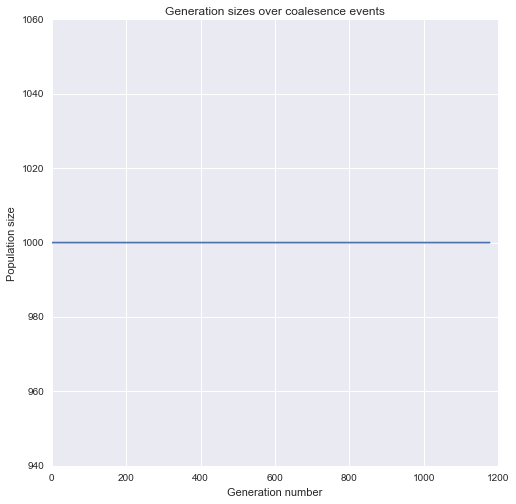

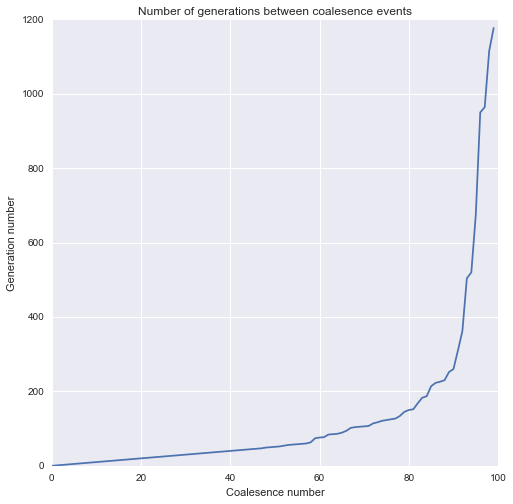

In [559]:
# fig = plt.figure(figsize=(8,8))
# plt.plot(range(len(generation_sizes)), generation_sizes);
# plt.title('Generation sizes over coalesence events')
# plt.xlabel('Generation number')
# plt.ylabel('Population size');

# fig = plt.figure(figsize=(8,8))
# plt.plot(range(len(coal_lengths)), coal_lengths);
# plt.title('Number of generations between coalesence events')
# plt.ylabel('Generation number')
# plt.xlabel('Coalesence number');

# # plt.plot(generation_sizes, coal_lengths);
# # plt.title('Number of generations between coalesence events')
# # plt.ylabel('Generation number')
# # plt.xlabel('Coalesence number')